In [423]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random

%matplotlib inline

In [424]:
names = os.listdir('generated_captcha_images')
directory = 'generated_captcha_images/'
Names = [directory + name for name in names]

In [425]:
m = len(names)

In [426]:
def png2gray(png):
    ret = np.dot(png[...,:3],[0.299,0.587,0.144])
    return ret / ret.max()

In [427]:
def ith_sample(i,show=True,data=False):
    fig = mpimg.imread(Names[i])
    fig = png2gray(fig)
    if show:
        plt.imshow(fig,cmap='gray')
    if data:
        word = Names[i].split('/')
        word = word[1].split('.')
        word = word[0]
        return fig,word

## 查看图片

In [429]:
choice = np.arange(m)

random.shuffle(choice)

fig = np.zeros((15*24,5*72))

for i in range(15*5):
    row = int(i/5)
    col = i%5
    fig[24*row:24*(row+1),72*col:72*(col+1)] = ith_sample(choice[i],show=False,data=True)

plt.imshow(fig,cmap='gray')

ValueError: could not broadcast input array from shape (2) into shape (24,72)

## 图片分割

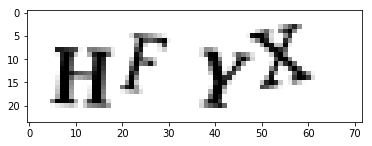

In [52]:
fig = ith_sample(1,show=True,data=True)

In [145]:
white_border = []
n = fig.shape[1]
for i in range(n):
    if (fig[:,i] <= 0.5).any():
        white_border.append(i)
white_border

[6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60]

In [305]:
def border2split(border): # 将 border 转化为区间
    n = len(border)
    result = []
    last = border[0]
    for i in range(1,n):
        if border[i] - border[i-1] == 1:
            continue
        else:
            result.append((last,border[i-1]))
            last = border[i]
    result.append((last,border[n-1]))
    return result

In [395]:
def width_detect(border,threshold=12): # 将宽度大于threshold的区间平均分成两块
    
    lt = 0 # 小于4
    mt = 0 # 大于4
    
    if len(border) == 4: # 本身4个区间，则无需分割
        return border,lt,mt
    
    result = []
    
    for st,ed in border:
        if ed - st > threshold:
            mid = int((st + ed) / 2)
            result.append((st,mid))
            result.append((mid,ed))
        else:
            result.append((st,ed))
    
    
    if len(result) > 4 :
        mt = 1
        print('more than 4 splits')
    if len(result) < 4:
        lt= 1
        print('less than 4 splits')
    # 下面这部分是用来将小的区间合并成大的区间，但是这样并不好，因为“1”“i”这些字母的占位都很窄
    '''while len(result) > 4:
        print('reduce strategy:\n',result)
        minimum = 100
        rec = -1
        index = 0
        for st,ed in result:
            if ed - st < minimum:
                minimum = ed - st
                rec = index
            index += 1
        
        if index == len(result) - 1:
            tp1 = result.pop(len(result)-1)
            tp2 = result.pop(len(result)-1)
            result.append((tp1[0],tp2[1]))
        elif index == 0:
            tp1 = result.pop(0)
            tp2 = result.pop(0)
            result.append((tp1[0],tp2[1]))
        else:
            la = result[index-1][1] - result[index-1][0]
            ne = result[index+1][1] - result[index+1][0]
            
            if la <= ne:
                tp1 = result.pop(index-1)
                tp2 = result.pop(index-1)
                result.append((tp1[0],tp2[1]))
            else:
                tp1 = result.pop(index)
                tp2 = result.pop(index)
                result.append((tp1[0],tp2[1]))
        print('---->\n',result)'''
        
    return result,lt,mt

border = border2split(white_border)
border = width_detect(border)
print(border)

([(6, 17), (20, 29), (38, 49), (49, 60)], 0, 0)


In [342]:
def border2show(fig,border,word,show_word=False,offset=False,show=True,data=False): # 根据区间显示划分结果并返回数据
    point_num = len(border)
    fig_num = 0
    ret = 0.5 * np.ones((24,2))
    Data = []
    
    index = 0
    mids = np.zeros((4,),dtype=np.int16)
    
    for st,ed in border:
        to_combine = fig[:,st:ed]
        
        if offset or data:
            width = ed - st
            left = int((24 - width)/2)
            right = 24 - width - left
            to_combine = np.hstack((np.ones((24,left)),to_combine,np.ones((24,right))))
            if data:
                Data.append(to_combine)
                
        if show_word and index < 4:
            left = ret.shape[1]
            right = to_combine.shape[1]
            mids[index] = int((2*left+right)/2) + 5
        
        index += 1
        
        
        ret = np.hstack((ret,to_combine))
        ret = np.hstack((ret,0.5*np.ones((24,2))))
        
        
    ret = np.vstack((0.5*np.ones((2,ret.shape[1])),ret,0.5*np.ones((2,ret.shape[1]))))
    if show:
        plt.imshow(ret,cmap='gray')
        
        if show_word:
            for i in range(4):
                plt.text(mids[i],8,word[i],fontsize=20)
            
    if data:
        result = [(Data[i],word[i]) for i in range(4)]
        
        return result

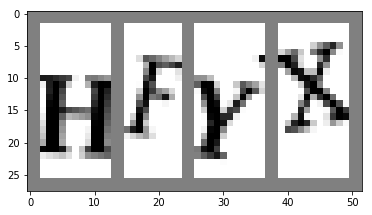

In [217]:
border2show(fig,border)

In [394]:
def split_ith_sample(i,offset=False,data=False,show_word=False,show=True,color_threshold=0.99,width_threshold=15):
    fig,word = ith_sample(i,data=True,show=False)
    white_border = []
    n = fig.shape[1]
    for i in range(n):
        if (fig[:,i] <= color_threshold).any():
            white_border.append(i)
    border = border2split(white_border)
    border,lt,mt = width_detect(border,width_threshold)
    Data = border2show(fig,border,word=word,show_word=show_word,offset=offset,show=show,data=data)
    if data:
        return Data
    else:
        return lt,mt
        

## split_ith_sample参数
* **offset** 是否把图像填充成正方形
* **show** 是否展示图片
* **data** 是否返回数据
* **show_word** 是否在图片中展示标记
* **width_threshold** 对每个字符长度最大值的限制，超过这个值会将一个字符平均分割为两个 默认15(=12->10,=14->16,=15->149)
* **color_threshold** 对分割精度的限制，因为图片中0表示黑色，1表示白色，这个参数越大则每个字符占位越广，越小则每个字符占位越窄 默认0.99


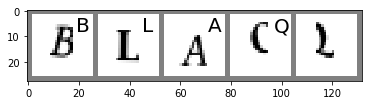

In [343]:
split_ith_sample(10,offset=True,show_word=True,width_threshold=12)

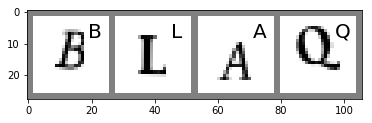

In [344]:
split_ith_sample(10,offset=True,show_word=True,width_threshold=14)

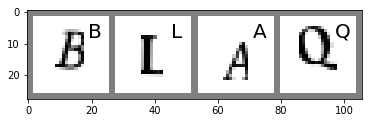

In [346]:
split_ith_sample(10,offset=True,show_word=True,width_threshold=14,color_threshold=0.3)

In [413]:
lessthan = 0
morethan = 0
for i in range(m):
    print('{}th'.format(i))
    lt,mt = split_ith_sample(i,show=False,width_threshold=17)
    lessthan += lt
    morethan += mt

0th
1th
2th
3th
4th
5th
6th
7th
8th
9th
10th
11th
12th
13th
14th
15th
16th
17th
18th
19th
20th
21th
22th
23th
24th
25th
26th
27th
28th
29th
30th
31th
32th
33th
34th
35th
36th
37th
38th
39th
40th
41th
42th
43th
44th
45th
46th
47th
48th
49th
50th
51th
52th
53th
54th
55th
56th
57th
58th
59th
60th
61th
62th
63th
64th
65th
66th
67th
68th
69th
70th
71th
72th
73th
74th
75th
76th
77th
78th
79th
80th
81th
82th
83th
84th
85th
86th
87th
88th
89th
90th
91th
92th
93th
94th
95th
96th
97th
98th
99th
100th
101th
102th
103th
104th
105th
106th
107th
108th
109th
110th
111th
112th
113th
114th
115th
less than 4 splits
116th
117th
118th
119th
120th
121th
122th
123th
124th
125th
126th
127th
128th
129th
130th
131th
132th
133th
134th
less than 4 splits
135th
136th
137th
138th
139th
140th
141th
142th
143th
144th
145th
less than 4 splits
146th
147th
148th
149th
150th
151th
152th
153th
154th
155th
156th
157th
158th
159th
160th
161th
162th
163th
164th
165th
166th
167th
168th
169th
170th
171th
172th
173th
174th
175

1554th
1555th
1556th
1557th
1558th
1559th
1560th
1561th
1562th
1563th
1564th
1565th
1566th
1567th
1568th
1569th
1570th
1571th
1572th
1573th
1574th
1575th
1576th
1577th
1578th
1579th
1580th
1581th
1582th
1583th
1584th
1585th
1586th
1587th
1588th
1589th
1590th
1591th
1592th
1593th
1594th
1595th
1596th
1597th
1598th
1599th
1600th
1601th
1602th
1603th
1604th
1605th
1606th
1607th
1608th
1609th
1610th
1611th
less than 4 splits
1612th
1613th
1614th
1615th
1616th
1617th
1618th
1619th
1620th
1621th
1622th
1623th
1624th
1625th
1626th
1627th
1628th
1629th
1630th
1631th
1632th
1633th
1634th
1635th
1636th
1637th
1638th
1639th
1640th
1641th
1642th
1643th
1644th
1645th
1646th
1647th
1648th
1649th
1650th
1651th
1652th
1653th
1654th
1655th
1656th
1657th
1658th
1659th
1660th
1661th
1662th
1663th
1664th
1665th
1666th
1667th
1668th
1669th
1670th
1671th
1672th
1673th
1674th
1675th
1676th
1677th
1678th
1679th
1680th
1681th
1682th
1683th
1684th
1685th
1686th
1687th
1688th
1689th
1690th
1691th
1692th
1693th
1

2714th
2715th
2716th
2717th
2718th
2719th
2720th
2721th
2722th
2723th
2724th
2725th
2726th
2727th
2728th
2729th
2730th
2731th
2732th
2733th
2734th
2735th
2736th
2737th
2738th
2739th
2740th
2741th
2742th
2743th
2744th
2745th
2746th
2747th
2748th
2749th
2750th
2751th
2752th
2753th
2754th
2755th
2756th
2757th
2758th
2759th
2760th
2761th
2762th
2763th
2764th
2765th
2766th
2767th
2768th
2769th
2770th
2771th
2772th
2773th
2774th
2775th
2776th
2777th
2778th
2779th
2780th
2781th
2782th
2783th
2784th
2785th
2786th
2787th
2788th
2789th
2790th
2791th
2792th
2793th
2794th
2795th
2796th
2797th
2798th
2799th
2800th
2801th
2802th
2803th
2804th
2805th
2806th
2807th
2808th
2809th
2810th
2811th
2812th
2813th
2814th
2815th
2816th
2817th
2818th
2819th
2820th
2821th
2822th
2823th
2824th
2825th
2826th
2827th
2828th
2829th
2830th
2831th
2832th
2833th
2834th
2835th
2836th
2837th
2838th
2839th
2840th
2841th
2842th
2843th
2844th
2845th
2846th
2847th
2848th
2849th
2850th
2851th
2852th
2853th
2854th
2855th
2856th

3923th
3924th
3925th
3926th
3927th
3928th
3929th
3930th
3931th
3932th
3933th
3934th
3935th
3936th
3937th
3938th
3939th
3940th
3941th
3942th
3943th
3944th
3945th
3946th
3947th
3948th
3949th
3950th
3951th
3952th
3953th
3954th
3955th
3956th
3957th
3958th
3959th
3960th
3961th
3962th
3963th
3964th
3965th
3966th
3967th
3968th
3969th
3970th
3971th
3972th
3973th
3974th
3975th
3976th
3977th
3978th
3979th
3980th
3981th
3982th
3983th
3984th
3985th
3986th
3987th
3988th
3989th
3990th
3991th
3992th
3993th
3994th
3995th
3996th
3997th
3998th
3999th
4000th
less than 4 splits
4001th
4002th
4003th
4004th
4005th
4006th
4007th
4008th
4009th
4010th
4011th
4012th
4013th
4014th
4015th
4016th
4017th
4018th
4019th
4020th
4021th
4022th
less than 4 splits
4023th
4024th
4025th
4026th
4027th
4028th
4029th
4030th
4031th
4032th
4033th
4034th
4035th
4036th
4037th
4038th
4039th
4040th
4041th
4042th
4043th
4044th
4045th
4046th
4047th
4048th
4049th
4050th
4051th
4052th
4053th
less than 4 splits
4054th
4055th
4056th
4057t

5117th
5118th
5119th
5120th
5121th
5122th
5123th
5124th
5125th
5126th
5127th
5128th
5129th
less than 4 splits
5130th
5131th
5132th
5133th
5134th
5135th
5136th
5137th
5138th
5139th
5140th
5141th
5142th
5143th
5144th
5145th
5146th
5147th
5148th
less than 4 splits
5149th
5150th
5151th
less than 4 splits
5152th
5153th
5154th
5155th
5156th
5157th
5158th
5159th
5160th
5161th
5162th
5163th
5164th
5165th
5166th
5167th
5168th
5169th
5170th
5171th
less than 4 splits
5172th
5173th
5174th
5175th
5176th
5177th
5178th
5179th
5180th
5181th
5182th
less than 4 splits
5183th
5184th
5185th
5186th
5187th
5188th
5189th
5190th
5191th
5192th
5193th
5194th
5195th
5196th
5197th
5198th
less than 4 splits
5199th
5200th
5201th
5202th
5203th
5204th
5205th
5206th
5207th
5208th
5209th
5210th
5211th
5212th
5213th
5214th
5215th
5216th
5217th
5218th
5219th
5220th
5221th
5222th
less than 4 splits
5223th
5224th
5225th
5226th
5227th
5228th
5229th
5230th
5231th
5232th
5233th
5234th
5235th
5236th
5237th
5238th
5239th
5240th

6293th
6294th
6295th
6296th
6297th
6298th
6299th
6300th
6301th
6302th
6303th
6304th
6305th
6306th
6307th
6308th
6309th
6310th
6311th
6312th
6313th
6314th
6315th
6316th
6317th
6318th
6319th
6320th
6321th
6322th
6323th
6324th
6325th
6326th
6327th
6328th
6329th
6330th
6331th
6332th
6333th
6334th
6335th
6336th
6337th
6338th
6339th
6340th
6341th
6342th
6343th
6344th
6345th
6346th
6347th
6348th
6349th
6350th
6351th
6352th
6353th
6354th
6355th
6356th
6357th
6358th
6359th
6360th
6361th
6362th
6363th
6364th
6365th
6366th
6367th
6368th
6369th
6370th
6371th
6372th
6373th
6374th
6375th
6376th
6377th
6378th
6379th
6380th
6381th
6382th
6383th
6384th
6385th
6386th
6387th
6388th
6389th
6390th
6391th
6392th
6393th
6394th
6395th
6396th
6397th
6398th
6399th
6400th
6401th
6402th
less than 4 splits
6403th
6404th
6405th
6406th
6407th
6408th
6409th
6410th
6411th
6412th
6413th
6414th
6415th
6416th
6417th
6418th
6419th
6420th
6421th
6422th
6423th
6424th
6425th
6426th
6427th
6428th
6429th
6430th
6431th
6432th
6

7530th
7531th
7532th
7533th
7534th
7535th
7536th
7537th
7538th
7539th
7540th
7541th
7542th
7543th
7544th
7545th
7546th
7547th
7548th
7549th
7550th
7551th
7552th
7553th
7554th
7555th
7556th
7557th
7558th
7559th
7560th
7561th
7562th
7563th
7564th
7565th
7566th
7567th
7568th
7569th
7570th
7571th
7572th
7573th
7574th
7575th
7576th
7577th
7578th
7579th
7580th
7581th
7582th
7583th
7584th
7585th
7586th
7587th
7588th
7589th
7590th
7591th
7592th
7593th
7594th
7595th
7596th
7597th
7598th
7599th
7600th
7601th
7602th
7603th
7604th
7605th
7606th
7607th
7608th
7609th
7610th
7611th
7612th
7613th
7614th
less than 4 splits
7615th
7616th
7617th
7618th
7619th
7620th
7621th
7622th
7623th
7624th
7625th
7626th
7627th
7628th
7629th
7630th
7631th
7632th
7633th
7634th
7635th
7636th
7637th
7638th
7639th
7640th
7641th
7642th
7643th
7644th
7645th
7646th
7647th
7648th
7649th
7650th
7651th
7652th
7653th
7654th
7655th
7656th
7657th
7658th
7659th
7660th
7661th
7662th
7663th
7664th
7665th
7666th
less than 4 splits
766

8711th
8712th
8713th
8714th
8715th
8716th
8717th
8718th
8719th
8720th
8721th
8722th
8723th
8724th
8725th
8726th
8727th
8728th
8729th
8730th
8731th
8732th
8733th
8734th
8735th
8736th
8737th
8738th
8739th
8740th
8741th
8742th
8743th
8744th
8745th
8746th
8747th
8748th
8749th
8750th
8751th
8752th
8753th
8754th
8755th
8756th
8757th
8758th
8759th
8760th
8761th
8762th
8763th
8764th
8765th
8766th
8767th
8768th
8769th
8770th
8771th
8772th
8773th
8774th
8775th
8776th
8777th
8778th
8779th
8780th
8781th
8782th
less than 4 splits
8783th
8784th
8785th
8786th
8787th
8788th
8789th
8790th
8791th
8792th
8793th
8794th
8795th
8796th
8797th
8798th
8799th
8800th
8801th
8802th
8803th
8804th
8805th
8806th
8807th
8808th
8809th
8810th
8811th
8812th
8813th
8814th
8815th
8816th
8817th
8818th
8819th
8820th
8821th
8822th
8823th
8824th
8825th
8826th
8827th
8828th
8829th
8830th
8831th
8832th
8833th
8834th
8835th
8836th
8837th
8838th
8839th
8840th
8841th
8842th
8843th
8844th
8845th
8846th
8847th
8848th
8849th
8850th
8

9931th
9932th
9933th
9934th
9935th
9936th
9937th
9938th
9939th
9940th
9941th
9942th
9943th
9944th
9945th
9946th
9947th
9948th
9949th
9950th
9951th
9952th
9953th
9954th


In [406]:
print('less than 4:{},more than 4 :{}, accuracy:{:.4f}%'.format(lessthan,morethan,(m-lessthan-morethan)/m*100))# 14

less than 4:128,more than 4 :99, accuracy:97.7197%


In [410]:
print('less than 4:{},more than 4 :{}, accuracy:{:.4f}%'.format(lessthan,morethan,(m-lessthan-morethan)/m*100))# 15

less than 4:130,more than 4 :37, accuracy:98.3225%


In [412]:
print('less than 4:{},more than 4 :{}, accuracy:{:.4f}%'.format(lessthan,morethan,(m-lessthan-morethan)/m*100))# 16

less than 4:134,more than 4 :3, accuracy:98.6238%


In [414]:
print('less than 4:{},more than 4 :{}, accuracy:{:.4f}%'.format(lessthan,morethan,(m-lessthan-morethan)/m*100))# 17

less than 4:144,more than 4 :0, accuracy:98.5535%


(0, 0)

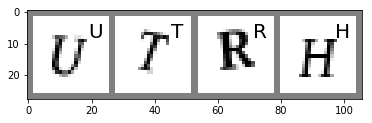

In [421]:
split_ith_sample(800,show=True,offset=True,show_word=True,width_threshold=14)

In [289]:
a

[2, 3]

In [291]:
a

[2]

In [430]:
1 + 1

2

In [431]:
2 * 3

6

In [432]:
fig

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

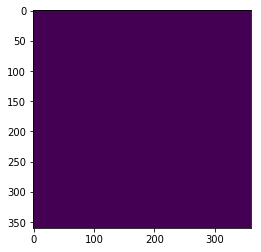

In [433]:
plt.imshow(fig)

In [436]:
fig[:,3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [441]:
a = np.array([[1,4],[2,3]])

In [442]:
a

array([[1, 4],
       [2, 3]])

In [443]:
a[:,1]

array([4, 3])

In [444]:
a[:,0]

array([1, 2])